# Fit One profile in All U,G,R,I Z band

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 26th 2020
- update date :


Study the relative atmosphere relative to an ideal profile in **libradtran/info_verbose/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**
- no aerosol
- pwv =4 mm
- ozone = 3000 DU
- No extinction coefficient
- airmass = 1


Fit components:

- h2o,
- o2,
- o3


The linear fit for the aerosols is added


In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [52]:
from astropy.io import fits

In [53]:
from pprint import pprint # we use this to pretty print some stuff later

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

from iminuit import minimize  # has same interface as scipy.optimize.minimize

In [54]:
from datetime import datetime,date
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [55]:
#to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [56]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

## Filter boudaries

In [58]:
file_wavelengthbins="data/WaveLengthBins.csv"

In [59]:
df=pd.read_csv(file_wavelengthbins,index_col=0)

In [60]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [61]:
NBFILTER=len(df)

In [62]:
FILTER_NAME=df["band"].values
WL_MIN=df["wl_min"].values
WL_MAX=df["wl_max"].values
WL_WIDTH=df["wl_wdth"].values

## Absorption pattern

In [63]:
file_abspattern="data/absorption_pattern.csv"

In [64]:
df_atm=pd.read_csv(file_abspattern,index_col=0)

In [65]:
print(df_atm.columns.tolist())

['wl', 'o2_10', 'o2_11', 'o2_12', 'o2_13', 'o2_14', 'o2_15', 'o2_16', 'o2_17', 'o2_18', 'o2_19', 'o2_20', 'o2_21', 'o2_22', 'o2_23', 'o2_24', 'o2_25', 'o3_10', 'o3_11', 'o3_12', 'o3_13', 'o3_14', 'o3_15', 'o3_16', 'o3_17', 'o3_18', 'o3_19', 'o3_20', 'o3_21', 'o3_22', 'o3_23', 'o3_24', 'o3_25', 'h2o_10', 'h2o_11', 'h2o_12', 'h2o_13', 'h2o_14', 'h2o_15', 'h2o_16', 'h2o_17', 'h2o_18', 'h2o_19', 'h2o_20', 'h2o_21', 'h2o_22', 'h2o_23', 'h2o_24', 'h2o_25', 'no2_10', 'no2_11', 'no2_12', 'no2_13', 'no2_14', 'no2_15', 'no2_16', 'no2_17', 'no2_18', 'no2_19', 'no2_20', 'no2_21', 'no2_22', 'no2_23', 'no2_24', 'no2_25']


In [66]:
rootfilename=file_abspattern.split(".")[0]

In [67]:
all_df_atm=[]
for iband in np.arange(NBFILTER):
    filename=rootfilename+"_"+FILTER_NAME[iband]+".csv"
    print("====================",filename,"=======================")
    df=pd.read_csv(filename,index_col=0)
    #df=df.reset_index(drop=True)
    all_df_atm.append(df)

==================== data/absorption_pattern_u.csv =======================
==================== data/absorption_pattern_g.csv =======================
==================== data/absorption_pattern_r.csv =======================
==================== data/absorption_pattern_i.csv =======================
==================== data/absorption_pattern_z.csv =======================
==================== data/absorption_pattern_y.csv =======================


## Atmospheric data

In [68]:
DATADIR="../data/atm"

## Reference atmosphere

In [69]:
data=np.loadtxt("data/RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT")
wl0=data[:,0]
transm0=data[:,1]

## Decoding function

In [70]:
def GetAtmosphericProfiles(dir,wl_ref,transm_ref):
    """
    """
    atmospheric_basename_files=os.listdir(dir)
    inputfile=os.path.join(DATADIR,atmospheric_basename_files[0])
    
    idx=0
    # containers
    all_data=[]
    all_hdr=[]
    all_wl=[]
    
    # loop on files
    for file in atmospheric_basename_files:
        inputfile=os.path.join(DATADIR,file)
        hdu = fits.open(inputfile)
        all_hdr.append(hdu[0].header)
        all_data.append(hdu[0].data[1:,:])
        all_wl.append(hdu[0].data[0,:])
        idx+=1
        hdu.close()
        
    data=np.vstack(all_data)
    hdr=all_hdr[0]
    
    #decode index from header
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    vaod=data[1:,idx_out_vaod] # vertical aerosol depth
    pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[1:,idx_out_o3]     # ozone
    cld=data[1:,idx_out_cld]   # clouds (not used)
    
    
    # Extract wavelength Wavelength
    wl=all_wl[0][idx_out_res:]
    transm=data[:,idx_out_res:]
    
    if len(wl)==len(wl_ref) and wl[0]== wl_ref[0]:
        transm/=transm_ref
    else:
        print("error reference does not match")
        
    
    return wl,transm,vaod,pwv,o3,cld
     

# Open all atmospheric files

In [71]:
wl,transm,vaod,pwv,o3,cld=GetAtmosphericProfiles(DATADIR,wl0,transm0)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [72]:
NBSIM=transm.shape[0]

# Distribute the relative transmission in the different filters

In [73]:
all_wl_filt=[]
all_transm_filt=[]
for iband in np.arange(NBFILTER):
    wl_indexes=np.where(np.logical_and(wl>=WL_MIN[iband],wl<=WL_MAX[iband]))[0]
    wl_filt=wl[wl_indexes]
    transm_filt=transm[:,wl_indexes]
    all_wl_filt.append(wl_filt)
    all_transm_filt.append(transm_filt)

In [74]:
all_transm_filt[0].shape

(3650, 79)

# Preview

In [75]:
IDX_SIM=0

In [76]:
# bins in wevelength
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSIM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSIM), alpha=1)

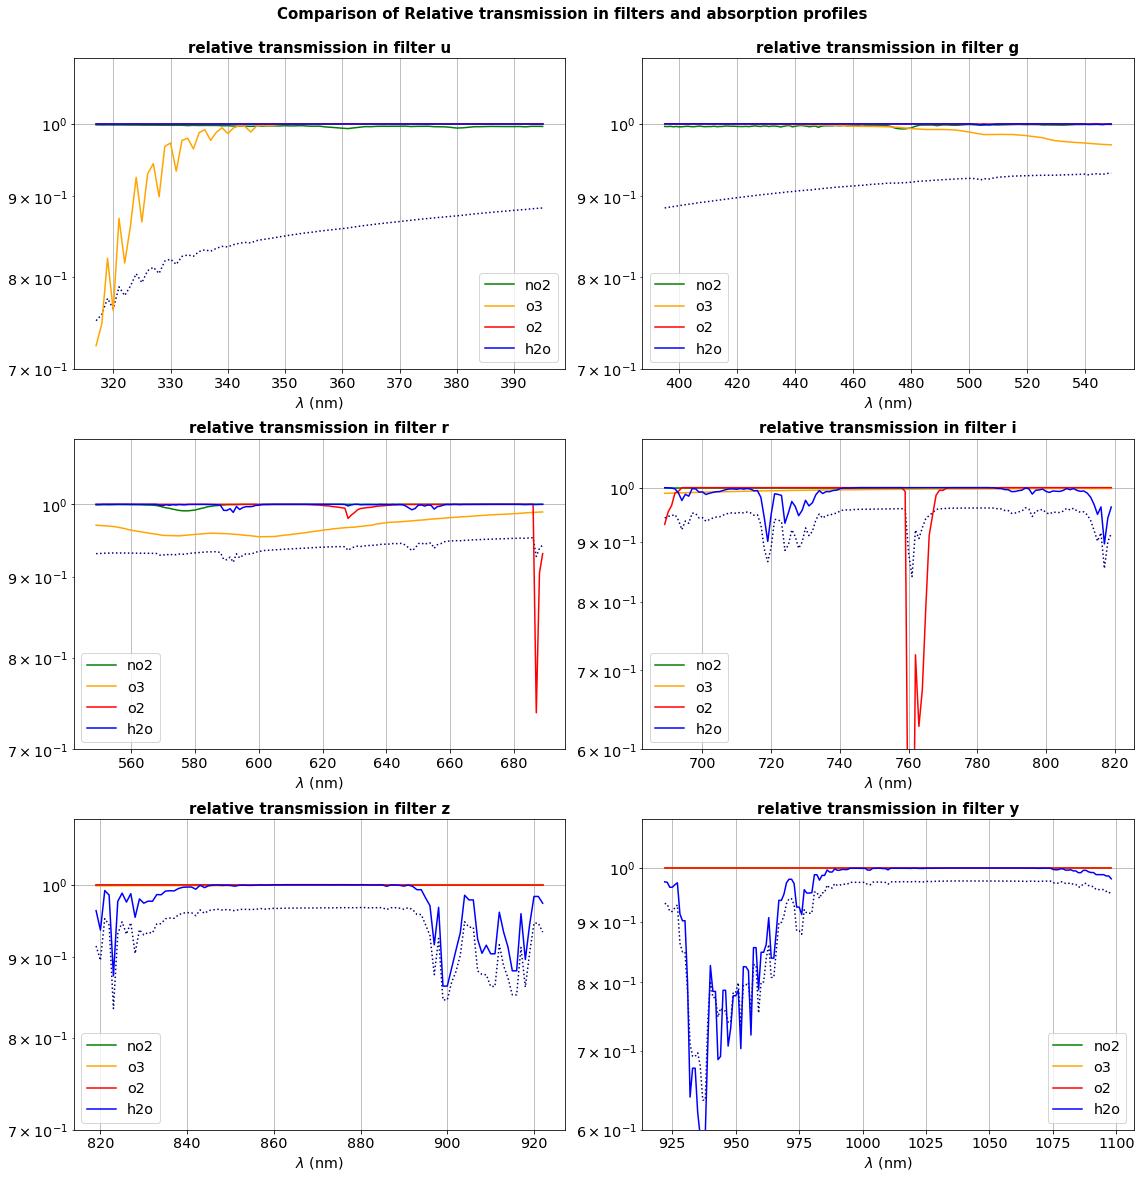

In [77]:
plt.figure(figsize=(16,16))
# loop on filter
for iband in np.arange(NBFILTER):
   
    wl=all_wl_filt[iband]
    transm=all_transm_filt[iband] 
    
    plt.subplot(3,2,iband+1)  
    # loop on simulation
    for idx in np.arange(IDX_SIM,IDX_SIM+1):
        
        colorVal=scalarMap.to_rgba(idx, alpha=1)
        plt.plot(wl,transm[idx,:],":",color=colorVal)
        
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["no2_12"],"g-",label="no2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o3_12"],"-",color="orange",label="o3")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["o2_12"],"r-",label="o2")
    plt.plot(all_df_atm[iband]["wl"],all_df_atm[iband]["h2o_12"],"b-",label="h2o")
            
    plt.grid(True)
    if iband<=2:
        plt.ylim(0.7,1.1)
    elif iband<=3:
        plt.ylim(0.6,1.1)
    elif iband<=4:
        plt.ylim(0.7,1.1)
    else:
        plt.ylim(0.6,1.1)
        
    plt.yscale("log")
    plt.xlabel("$\lambda$ (nm)")
    plt.legend(loc="best")
    title="relative transmission in filter {}".format(FILTER_NAME[iband])
    plt.title(title,fontweight="bold",fontsize=15)
plt.suptitle("Comparison of Relative transmission in filters and absorption profiles",fontweight="bold",fontsize=15,y=1.02)
figname=string_date+"_RelativeTransmissionFiltersAndAbsPatterns.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()  

# Fit

## Definition of the parameter structure

- params is defined as follow

### First components

- h2o
- o2
- o3

#### Continuous background

- a0 : grey term
- s1 : slope in Z band
- s2 : slope in I band
- s3 : slope in R band
- s4 : slope in G band
- s5 : slope in U band

In [78]:
PARAMS_NAMES = ["h2o","o2","o3","a0","s1","s2","s3","s4","s5"]
NPARAMS =len(PARAMS_NAMES )

#### Inititalisation 

In [79]:
PARAMS0_   = np.array([0,1])
PARAMSERR_ = np.array([0.0001,0.0001])   

## Flags

In [80]:
FLAG_FIT_U = False
FLAG_FIT_G = False
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [81]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

## Global variables

In [82]:
IBAND_     = 5
DATA_      = all_transm_filt[iband][IDX_SIM,:]
WL_        = all_wl_filt[iband]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern

## Fit function

In [83]:
def SetGlobals(iband):
    """
    Defines global variables used by fit function:
    
    DATA_     :  transmission ratio data
    PATTERNS_ :  array of absorption pattern
    WL_       :  wavelength
    
    """
    global IBAND_       # Current band 
    global DATA_        # transmission ratio data
    global PATTERNS_    # array of absorption pattern
    global WL_          # wavelength
    
    IBAND_     = iband
    DATA_      = all_transm_filt[iband][IDX_SIM,:]
    WL_        = all_wl_filt[iband]
    PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values , all_df_atm[iband]["o3_12"].values] # only one pattern


In [84]:
def ContinuousComponent(x,cparams):
    """
    ContinuousComponent(x,iband,cparams):
    
    input argument :
     x     : wavelength, can be a numpy array
    
    """
    
    a0=cparam[0]
    a1=cparam[1]
    a2=cparam[2]
    a3=cparam[3]
    a4=cparam[4]
    a5=cparam[5]
    
    x0=WL_MIN[0]
    x1=WL_MIN[1]
    x2=WL_MIN[2]
    x3=WL_MIN[3]
    x4=WL_MIN[4]
    x5=WL_MIN[5]
    x6=WL_MAX[5]
    
    w0=x6-x5
    w1=x5-x4
    w2=x4-x3
    w3=x3-x2
    w4=x2-x1
    w5=x1-x0
    
    
    if   IBAND_ == 5 :    # Y band
        y = a0
    elif IBAND_ == 4 : # Z band
        y = a0 + a1*(x-x5)
    elif IBAND_ == 3 : # I band
        y = a0 - a1*w1 + a2*(x-x4)
    elif IBAND_ == 2 : # R band
        y = a0 - a1*w1 - a2*w2 + a3*(x-x3)
    elif IBAND_ == 1 : # R band
        y = a0 - a1*w1 - a2*w2 - a3*w3 +a4*(x-x2)
    elif IBAND_ == 0 : # R band
        y = a0 - a1*w1 - a2*w2 - a3*w3 +a4*w4 + a5*(x-x1)
    
    return y

In [91]:
NBPATTERNS=len(PATTERNS_)    # number of absorption patterns in the model
CPARAMS=PARAMS0_[NBPATTERNS:-1]  # parameters for the continuous modem

In [95]:
CPARAMS

array([], dtype=int64)

In [93]:
NBPATTERNS

3

In [94]:
# create the model, one value per wavelength in the band (numpy array)
model=np.zeros(DATA_.shape)

In [86]:
def ModelInBand(params):
    """
    """
    NBPATTERNS=len(PATTERNS_)    # number of absorption patterns in the model
    CPARAMS=params[NBPATTERNS:]  # parameters for the continuous modem
    
    # create the model, one value per wavelength in the band (numpy array)
    model=np.zeros(DATA_.shape)
    
    for idx_component in np.arange(NBPATTERNS):
        model += params[idx_component]*PATTERNS_[idx_component]
        
    # add the continuous model    
    model+ = ContinuousComponent(WL_,CPARAMS)
    
    return model  

SyntaxError: invalid syntax (<ipython-input-86-bd2bca644c53>, line 14)

In [ ]:
def Chi2OneFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    
    global DATA_
    
    
    model = ModelInBand(params)
   
    diff=DATA_- model
        
    diff2=diff**2    # compute the difference 
    chi2=diff2.sum() # compute the sum
    
    return chi2
    

# Fit in Three bands

## Fit in Y filter : H2O and Grey scale

In [ ]:
iband=5

In [ ]:
IBAND_     = 5
WL_        = all_wl_filt[iband]
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values] # only one pattern
PARAMS0_   = np.array([0,1])
PARAMSERR_ = np.array([0.0001,0.0001])

In [ ]:
m = Minuit.from_array_func(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, name = ("grey", "h2o"),errordef=1)
m.get_param_states()

In [ ]:
m.migrad()

In [ ]:
#minimize(Chi2OneFiltAbsPatternAndGrey_np, PARAMS0_)

In [ ]:
grey_fit=m.values[0]
h2o_fit=m.values[1]
grey_fit_err=m.errors[0]
h2o_fit_err=m.errors[1]

In [ ]:
wl=all_wl_filt[iband]
transm=all_transm_filt[iband][IDX_SIM,:]

In [ ]:
plt.title("Fit in Y band")
plt.plot(wl,transm,"k-",label="data")
label="fit grey={:1.3f} +/- {:1.3f}, h2o={:1.3f}+/- {:1.3f} ".format(grey_fit,grey_fit_err,h2o_fit,h2o_fit_err)
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0],'r-',label=label)
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

## Fit in all bands

In [ ]:
grey_0 = grey_fit
h2o_0  = h2o_fit
o2_0   = 1.
o3_0   = 1.


In [ ]:
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values , all_df_atm[iband]["o2_12"].values, all_df_atm[iband]["o3_12"].values ] # only one pattern
PARAMS0_   = np.array([grey_0,h2o_0,o2_0,o3_0])
PARAMSERR_ = np.array([0.0001,0.0001,0.0001,0.0001])

In [ ]:
FLAG_FIT_U = False
FLAG_FIT_G = False
FLAG_FIT_R = True
FLAG_FIT_I = True
FLAG_FIT_Z = True
FLAG_FIT_Y = True

In [ ]:
FLAGS_FIT_SEL = np.array([FLAG_FIT_Y,FLAG_FIT_Z,FLAG_FIT_I,FLAG_FIT_R,FLAG_FIT_G,FLAG_FIT_U])
FLAGS_FIT_NUM = np.array([5,4,3,2,1,0])

In [ ]:
def Chi2ManyFiltAbsPatternAndGrey_np(params):
    """
    Chi2(data,patterns,params) compute the chi2 in one band
    
    The format is complient with iMinuit
    
    External DATA_,PATTERNS_
    
    
    - data: one numpy array of data (ratio for each wavelength bin)
    - patterns : list of arrays of absorption patterns
    - params : array of values one grey plus one factor for each of the pattern 
    
    The data and the patterns much match in size
    
    Compute the chi2: 
    
    Note no error is probided at the moment
    
    """
    # first band
    
    
    global DATA_
    global PATTERNS_
    
    
    chi2=0
    
    # loop on bands starting by Y only for validated 
    for idx,iband in np.ndenumerate(FLAGS_FIT_NUM):
        
        if FLAGS_FIT_SEL[idx[0]]:    
            
            DATA_      = all_transm_filt[iband][IDX_SIM,:]
            PATTERNS_   = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values, all_df_atm[iband]["o3_12"].values] # only one pattern

            chi2+=Chi2OneFiltAbsPatternAndGrey_np(params)     # Compute for that band
            
    return chi2
    

In [ ]:
m = Minuit.from_array_func(Chi2ManyFiltAbsPatternAndGrey_np, PARAMS0_, error=PARAMSERR_, name = ("grey", "h2o","o2","o3"),errordef=1)
m.get_param_states()

In [ ]:
m.migrad()

In [ ]:
grey_fit=m.values[0]
h2o_fit=m.values[1]
o2_fit=m.values[2]
o3_fit=m.values[3]
grey_fit_err=m.errors[0]
h2o_fit_err=m.errors[1]
o2_fit_err=m.errors[2]
o3_fit_err=m.errors[3]

In [ ]:


plt.figure(figsize=(16,16))
#---------------------------------


#----------------------------------

plt.subplot(3,2,1)
iband=0
wl=all_wl_filt[iband]
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values,all_df_atm[iband]["o3_12"].values ] # only one pattern

plt.title("Fit in G,R,I,Z band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]+o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------




#----------------------------------

plt.subplot(3,2,2)
iband=1
wl=all_wl_filt[iband]
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values,all_df_atm[iband]["o3_12"].values ] # only one pattern

plt.title("Fit in G,R,I,Z band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]+o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------



#----------------------------------

plt.subplot(3,2,3)
iband=2
wl=all_wl_filt[iband]
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values,all_df_atm[iband]["o3_12"].values ] # only one pattern

plt.title("Fit in G band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]+o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#-----------------


plt.subplot(3,2,4)
iband=3
wl=all_wl_filt[iband]
DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values ,all_df_atm[iband]["o3_12"].values ] # only one pattern

plt.title("Fit in I band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]+o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)

#------------------

plt.subplot(3,2,5)
iband=4
wl=all_wl_filt[iband]


DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values, all_df_atm[iband]["o3_12"].values] # only one pattern

plt.title("Fit in Z band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]+o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#-----------------------    

plt.subplot(3,2,6)
iband=5
wl=all_wl_filt[iband]
transm=all_transm_filt[iband][IDX_SIM,:]

DATA_      = all_transm_filt[iband][IDX_SIM,:]
PATTERNS_  = [all_df_atm[iband]["h2o_12"].values, all_df_atm[iband]["o2_12"].values,  all_df_atm[iband]["o3_12"].values] # only one pattern

plt.title("Fit in Y band")
plt.plot(wl,DATA_,"k-",label="data")
plt.plot(wl,grey_fit+h2o_fit*PATTERNS_[0]++o2_fit*PATTERNS_[1]+o3_fit*PATTERNS_[2],'r-',label="fit")
plt.grid()
plt.xlabel("$\lambda$ (nm)")
plt.legend()

#plt.yscale("log")
if iband<=2:
    plt.ylim(0.7,1.)
elif iband<=3:
    plt.ylim(0.8,1.)
elif iband<=4:
    plt.ylim(0.8,1.)
else:
    plt.ylim(0.6,1.)
    
#----------------------------    
plt.tight_layout()


suptitle="fit in R,I,Z,Y band grey={:1.3f} +/- {:1.3f}, h2o={:1.3f}+/- {:1.3f} , o2={:1.3f}+/- {:1.3f} , o3={:1.3f}+/- {:1.3f} ".format(grey_fit,grey_fit_err,h2o_fit,h2o_fit_err,o2_fit,o2_fit_err,o3_fit,o3_fit_err)
plt.suptitle(suptitle,y=1.02,fontweight="bold",fontsize=15)